## Sparse flight data

A key question for the generation of sparse state networks is _how_ sparse. If we lump all state nodes with each physical node, we loose all higher-order information and may underfit. On the other hand, keeping all second-order state nodes may overfit.

In this tutorial we will generate second-order state networks from path data and from there generate multiple sparse networks with different number of (lumped) state nodes and evaluate the result with Infomap

### Generate training and validation sets
To get a bigger network, we can merge the flight path data from the four quarters (`"data/air2015_{q}_paths.net" for q in [1,2,3,4]`). But to evaluate the goodness of fit, we can split each path randomly in either a _training_ or a _validation_ set and write a path data file for each of the data set.

**TODO:**
- Write a function that merges all paths of the year and writes it to a _training_ paths file with 50% chance and to a _validation_ paths file otherwise.

In [1]:
from random import random

def generateData(inputFilenames):
    """Merge path data from inputFilenames and write to two path data files
    for training and validation. Each path in the input data is selected by
    random to be written to either the training or validation data file"""
    data = { 'training': [], 'validation': [] }
    # Read path data
    for filename in inputFilenames:
        print("Parsing paths from '{}'...".format(filename))
        with open(filename, mode='r') as infile:
            # Skip heading
            next(infile)
            for row in infile:
                if random() < 0.5:
                    data['validation'].append(row)
                else:
                    data['training'].append(row)
    # Write path data
    for name, paths in data.items():
        outFilename = "../output/paths_{}.net".format(name)
        print("Writing {} paths to {}...".format(len(paths), outFilename))
        with open(outFilename, mode='w') as outfile:
            outfile.write("*paths\n")
            for p in paths:
                outfile.write(p)

inputFilenames = ["../data/air2015_{}_paths.net".format(quarter) for quarter in [1,2,3,4]]
generateData(inputFilenames)

Parsing paths from '../data/air2015_1_paths.net'...
Parsing paths from '../data/air2015_2_paths.net'...
Parsing paths from '../data/air2015_3_paths.net'...
Parsing paths from '../data/air2015_4_paths.net'...
Writing 33470 paths to ../output/paths_training.net...
Writing 33555 paths to ../output/paths_validation.net...


#### Generate state networks from paths

**TODO:**
- Use Infomap to generate second-order state networks from the two paths data files.

In [2]:
import infomap

def generateStateNetworkFromPaths(inputFilename, outputFilename, markovOrder):
    network = infomap.Network(infomap.Config("--directed --path-markov-order {}".format(markovOrder)))
    network.readInputData(inputFilename)
    network.writeStateNetwork(outputFilename)

generateStateNetworkFromPaths("../output/paths_training.net", "../output/states_training_order_2.net", 2)
generateStateNetworkFromPaths("../output/paths_validation.net", "../output/states_validation_order_2.net", 2)

### Generate _sparse_ state networks

Here we will generate multiple lumped state networks with different amount of state nodes. A simple way is to parameterise this with a cluster rate $r$ going from 0.1 to 1, where `n_clusters = max(1, int(r * numStateNodes)`. For convenience, you can just send in the argument `clusterRate` to `clusterStateNodes` to achieve this, instead of the cluster function in the previous tutorial.

**TODO:**
- Read in the training network with `StateNetwork`
- Calculate entropy rate
- Cluster the network for all cluster rates $r$ in for example `np.linspace(0.1, 1, 10)`.
- Save the number of lumped state nodes and the lumped entropy rate

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from state_lumping_network import StateNetwork

sparseNet = StateNetwork()
sparseNet.readFromFile("../output/states_training_order_2.net")

h0 = sparseNet.calcEntropyRate()
print("Original average entropy rate:", h0)

clusterRates = np.linspace(0.1, 1, 10)
# clusterRates = [0.25, 0.5, 0.75]
# clusterRates = [0.5]
numStates = []
entropyRate = []

for i, clusterRate in enumerate(clusterRates):
    sparseNet.clusterStateNodes(clusterRate=clusterRate)
    s = sparseNet.numLumpedStateNodes()
    h = sparseNet.calcLumpedEntropyRate()
    sparseNet.writeLumpedStateNetwork("../output/states_training_lumped_{}.net".format(i))
    numStates.append(s)
    entropyRate.append(h)

Read state network from file '../output/states_training_order_2.net'...
 -> StateNetwork (1988 physical nodes, 15915 state nodes and 44746 links)
Original average entropy rate: 3.7385495718856663
Cluster state nodes...
Generate lumped state network from clustering...
 -> 2285 state nodes and 17985 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_0.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 2728 state nodes and 21925 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_1.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 3184 state nodes and 25977 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_2.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 3696 state nodes and 29471 links in lumped network.
Writing lumped state network to file '../output/s

#### How much information do we loose as we reduce the number of state nodes?

**TODO:**
- Plot the entropy rate against the number of state nodes
- Check that the entropy rates approaches the original one and coincides at cluster rate $r = 1$

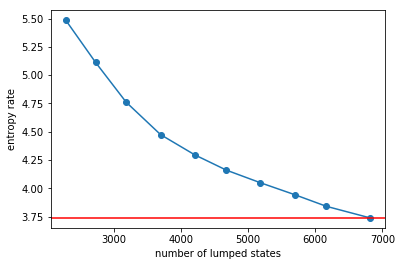

In [5]:
plt.plot(numStates, entropyRate, marker='o')
plt.xlabel("number of lumped states")
plt.ylabel("entropy rate")
plt.axhline(y=h0, color='r', linestyle='-')
# plt.axvline(x=sparseNet.numStateNodes(), color='r')
plt.show()

Note that the original number of state nodes (close to 16k) is much more than the maximum in the lumped state networks. This gap is due to the existence of dangling nodes wich are lumped implicitly.

### Validate with Infomap
The goal here is to calculate the codelength for the validation network, given the different partitions found on the lumped training networks.

**TODO:**
- Run Infomap on all lumped state networks and write a `.tree` file for each and store codelength
- Run Infomap on the validation network but with cluster data from external file for all `.tree` files generated from the lumped networks and store the codelength
- Plot the training and validation codelengths against the number of state nodes and check if there is an optimum that balances underfit and overfit